Setup

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras.callbacks import ModelCheckpoint
from creating_tfrecord import _parse_function

2024-02-28 20:15:47.822040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 20:15:47.823778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 20:15:48.059105: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 20:15:48.969852: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 20:16:01.736915: W tensorflow/compiler/tf2

Read dummy dataset

In [2]:
# Use multiple threads to read and preprocess the data
dataset = tf.data.TFRecordDataset('data.tfrecords')
dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [3]:
dataset

<_ParallelMapDataset element_spec=TensorSpec(shape=(10, 10, 10), dtype=tf.int64, name=None)>

Create a sampling layer

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Build the encoder

In [5]:
latent_dim = 56

encoder_inputs = keras.Input(shape=(10, 10))
# Add dense layer
x = layers.Dense(512, activation="relu")(encoder_inputs)
x = layers.Dense(512, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 10)]             0         []                            
                                                                                                  
 dense (Dense)               (None, 10, 512)              5632      ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 10, 512)              262656    ['dense[0][0]']               
                                                                                                  
 flatten (Flatten)           (None, 5120)                 0         ['dense_1[0][0]']             
                                                                                            

Build the decoder

In [6]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Reshape((1, 16))(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Flatten()(x)
decoder_outputs = layers.Dense(10 * 10, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((10, 10))(decoder_outputs)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 56)]              0         
                                                                 
 dense_3 (Dense)             (None, 16)                912       
                                                                 
 reshape (Reshape)           (None, 1, 16)             0         
                                                                 
 dense_4 (Dense)             (None, 1, 512)            8704      
                                                                 
 dense_5 (Dense)             (None, 1, 512)            262656    
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               5130

Define the VAE as a Model with a custom train_step

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(data, reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Instantiate the VAE model
vae = VAE(encoder=encoder, decoder=decoder)

# Compile the model
vae.compile(optimizer=tf.keras.optimizers.Adam())
num_epochs, batch_size = 10, 32

Epoch 1/10
100/100 [==============================] - 2s 3ms/step - loss: -396.1150 - reconstruction_loss: -628.1269 - kl_loss: 18.6861
Epoch 2/10
100/100 [==============================] - 0s 3ms/step - loss: -740.7444 - reconstruction_loss: -741.4127 - kl_loss: 8.1206e-04
Epoch 3/10
100/100 [==============================] - 0s 3ms/step - loss: -741.3152 - reconstruction_loss: -741.6414 - kl_loss: 9.1504e-04
Epoch 4/10
100/100 [==============================] - 0s 3ms/step - loss: -741.3372 - reconstruction_loss: -741.6627 - kl_loss: 9.6571e-04
Epoch 5/10
100/100 [==============================] - 0s 3ms/step - loss: -741.3380 - reconstruction_loss: -741.6646 - kl_loss: 9.7517e-04
Epoch 6/10
100/100 [==============================] - 0s 3ms/step - loss: -741.2865 - reconstruction_loss: -741.6189 - kl_loss: 0.0010
Epoch 7/10
100/100 [==============================] - 0s 3ms/step - loss: -741.3378 - reconstruction_loss: -741.6646 - kl_loss: 0.0011
Epoch 8/10
100/100 [==================

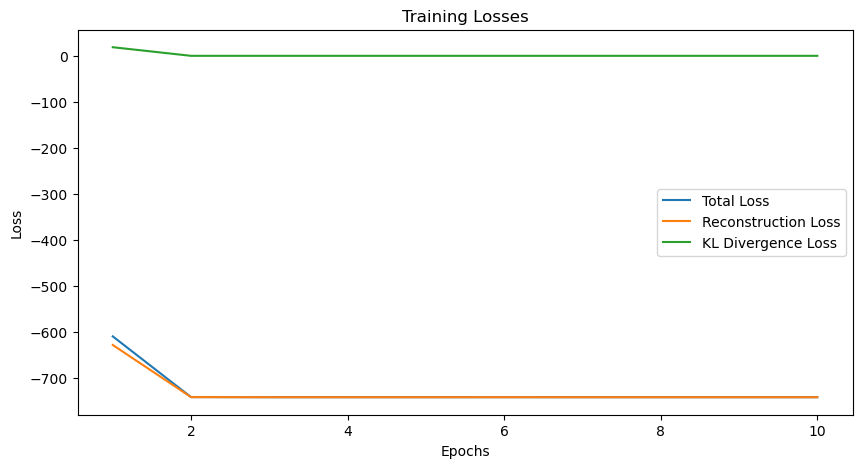

In [8]:
import matplotlib.pyplot as plt

# Assuming you've already trained the VAE using the code you provided

# Train the VAE model
history = vae.fit(dataset,
                epochs=num_epochs,
                batch_size=batch_size)

# Plot the losses over epochs
def plot_losses(history):
    loss = history.history['loss']
    reconstruction_loss = history.history['reconstruction_loss']
    kl_loss = history.history['kl_loss']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, label='Total Loss')
    plt.plot(epochs, reconstruction_loss, label='Reconstruction Loss')
    plt.plot(epochs, kl_loss, label='KL Divergence Loss')

    plt.title('Training Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_losses.png')
    plt.show()

# Plot the losses
plot_losses(history)